<a href="https://colab.research.google.com/github/arindamkeswani/RePlicator/blob/main/RePlicator_%5BTool_Notebook%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

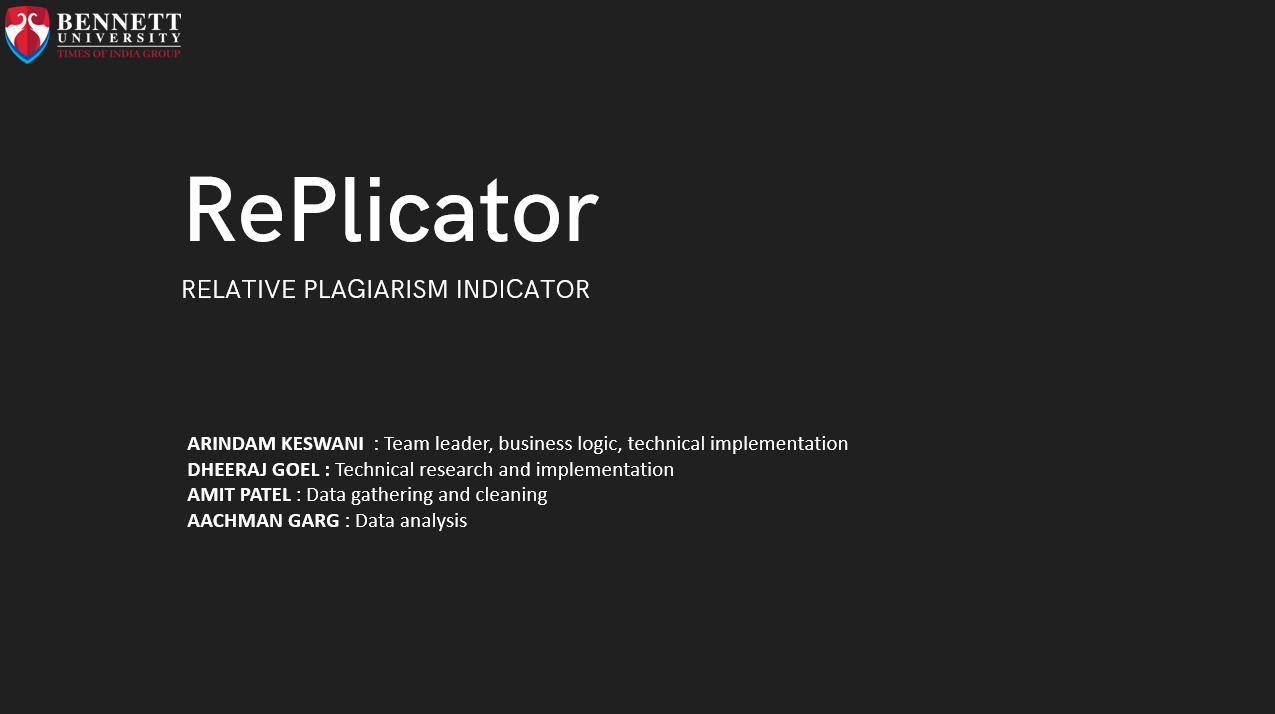

#**Research Summary:**
- 4 methodologies were implemented, tested, and compared, with time as the deciding metric:
  1. Serial implementation (for base time)
  2. Psuedo data-parallelism (purely for research purposes)
  3. Multiprocessing library (for base data-parallelism time)
  4. Numba library (for potential in-built optimum time)
- 5 Tests done on each methodology:
  1. Miniature Data [3 mini-files]
  2. Actual data [10 files]
  3. Actual data [26 files] [In-built cosine similarity]
  4. Actual data [26 files] [Manual cosine similarity]
  5. Actual data [50 files] [Manual cosine similarity]
- Mid-size dataset (20-30 files) saw a speed-up of `19.42%`, as compared to Serial time
- Large-size dataset (50+ files) saw a speed-up of `28.74%`, as compared to Serial time


---



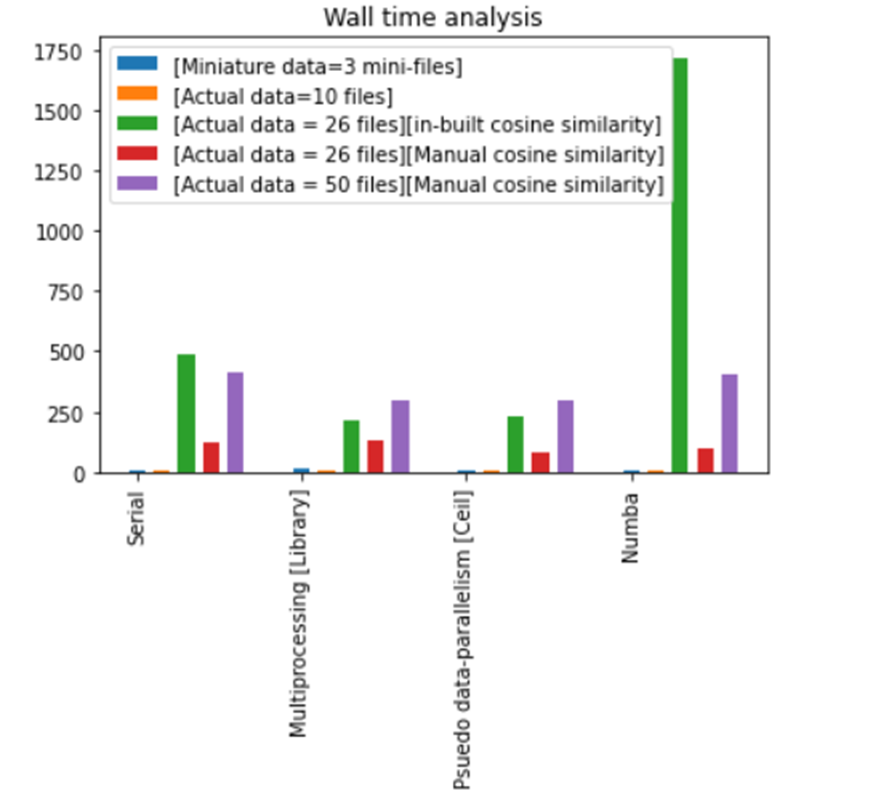

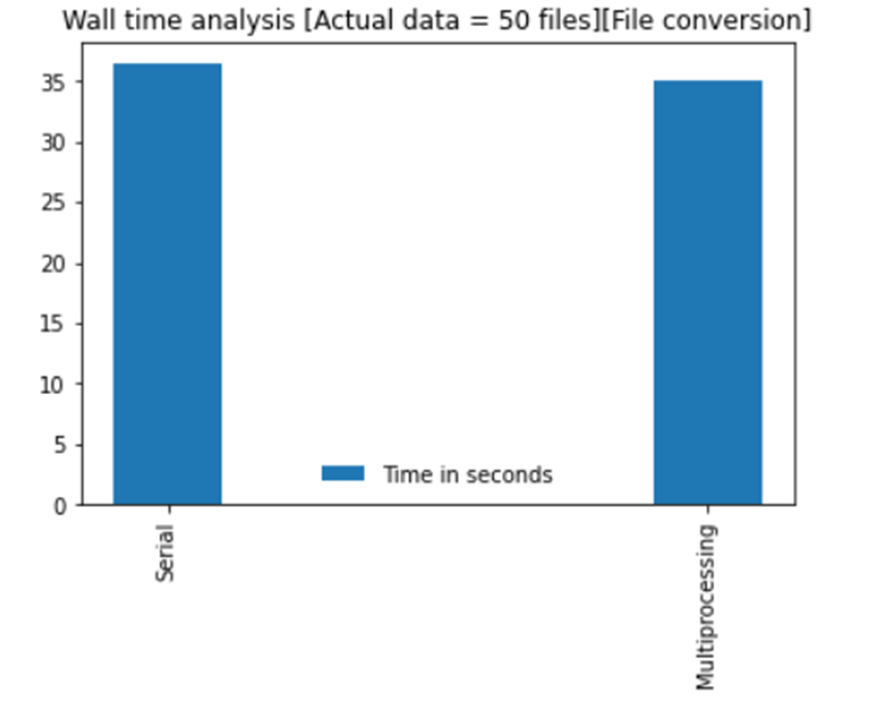

#Architecture

#Flow

#**Description:**
RePlicator (Relative Plagiarism Indicator) is a plagiarism indication tool meant to reduce the time taken to calculate level of plagiarism of a document with all the others in a dataset by using concepts of data-parallelism and libraries that work on similar principles.

Application targets can include research facilities, universities, etc. who need a comparative analysis of a certain set of documents.

Initially meant to be a research project, it was converted into an open-source tool with colab as its supporting platform, which enables users to use the tool **without worrying about licenses, hosting fees, and wasting memory on heavy applications.**


Currently supported file types: 
- .pdf
- .txt

**All the user needs to do is run the code cells step-by-step (guide below).**


---





#Steps to use the tool:
To run a code cell, simply press `[Shift + Enter]`

Follow the below steps in sequence
1. Click `Connect` on top right of the screen to **connect to the server**. You should see a green tick in a few seconds
2. Run cell in `Section 0` to **Import necessary libraries** for the tool to work
3. Run cell in `Section 1` to **Upload files**, when prompted
4. Run cell in `Section 2` for **PDF file processing**
5. Run cell in `Section 3` to **Check plagiarism**
6. Run cell in `Section 4` to **Display full table**
7. Run cell in `Section 5` to **Download full table**
8. Run cell in `Section 6` to **Download summarized table**


#**Section 0 : Import libraries**


In [2]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time
import pandas as pd
from numba import jit
from numba import njit

from os import system
import sys
from numpy import dot #Alt for cosine similarity
from numpy.linalg import norm #Alt for cosine similarity

import multiprocessing

!pip install PyPDF2
import PyPDF2 

# !pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from google.colab import files 


print("__________________________________________\n\nALL LIBRARIES IMPORTED")

     |████████████████████████████████| 81kB 2.8MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp37-none-any.whl size=61102 sha256=631d41fad09f46a775fb23dceaaaf3014210779c42a85d05c1372e0d7479a252
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
__________________________________________

ALL LIBRARIES IMPORTED


#**Section 1 : Upload files**

In [3]:
uploaded = files.upload()

print("__________________________________________\n\nALL FILES UPLOADED")

Saving Foucault5.pdf to Foucault5.pdf
Saving Foucault6.pdf to Foucault6.pdf
Saving Foucault7.pdf to Foucault7.pdf
Saving Shake5.pdf to Shake5.pdf
Saving Shake6.pdf to Shake6.pdf
Saving Shake7.pdf to Shake7.pdf
Saving Web1.pdf to Web1.pdf
Saving Web3.pdf to Web3.pdf
__________________________________________

ALL FILES UPLOADED


#**Section 2 : PDF File Processing**

In [4]:
student_files_pdf = [doc for doc in os.listdir() if doc.endswith('.pdf')]

# %%time
#Multiprocessing approach
# creating a pdf file object 
def convert2(student_files_pdf):
  for i in student_files_pdf:
    try:
      path=i
      pin='/content/'+path
      print(f"Converting {pin.split('/')[-1]}...")
      pout=pin[:-4]+".txt"
      print(pout)
      pdfFileObj = open(pin, 'rb') 
          
      # creating a pdf reader object 
      pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
          
      # printing number of pages in pdf file 
      print(f"Number of pages: {pdfReader.numPages}") 
          
      # creating a page object 
      s=""
      for i in range(pdfReader.numPages):
        pageObj = pdfReader.getPage(i) 
          
        # extracting text from page 
        
        s+=pageObj.extractText()
      print(f"Writing contents of {pin} to {pout}")
      myText = open(pout,'w')

      stop_words = set(stopwords.words('english'))
 
      word_tokens = word_tokenize(s)
      filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
 
      filtered_sentence = []
      
      for w in word_tokens:
          if w not in stop_words:
              filtered_sentence.append(w)
      
      sp = " "
  
      # joins elements of list1 by '-'
      # and stores in sting s

      filter_joined = sp.join(filtered_sentence)
      myText.write(filter_joined)
      myText.close()
      pdfFileObj.close()
      print('_'*100)
    except:
      print("Cannot convert",i)
      print('_'*100)
  
pool = multiprocessing.Pool(processes=2) 



l1 = student_files_pdf[:len(student_files_pdf)//2]
l2 = student_files_pdf[len(student_files_pdf)//2:]

start=time.time()

result = pool.map(convert2, [l1,l2])

for i in result:
  print(i)

Converting Shake5.pdf...
Converting Foucault5.pdf...
/content/Foucault5.txt
/content/Shake5.txt
Number of pages: 3
Number of pages: 15
Writing contents of /content/Shake5.pdf to /content/Shake5.txt
____________________________________________________________________________________________________
Converting Web3.pdf...
/content/Web3.txt


Number of pages: 8
Writing contents of /content/Web3.pdf to /content/Web3.txt
Writing contents of /content/Foucault5.pdf to /content/Foucault5.txt
____________________________________________________________________________________________________
Converting Web1.pdf...
/content/Web1.txt
Number of pages: 7
____________________________________________________________________________________________________
Converting Foucault7.pdf...
/content/Foucault7.txt
Number of pages: 20
Writing contents of /content/Web1.pdf to /content/Web1.txt
____________________________________________________________________________________________________
Converting Shake7.pdf...
/content/Shake7.txt
Number of pages: 5
Writing contents of /content/Shake7.pdf to /content/Shake7.txt
____________________________________________________________________________________________________
Writing contents of /content/Foucault7.pdf to /content/Foucault7.txt
_______________________________________________________________

#**Section 3 : Check plagiarism**

In [5]:
student_files = [doc for doc in os.listdir() if doc.endswith('.txt')] #store all text files
student_notes =[open(File).read() for File in  student_files] #stores all lines of all files

vectorize = lambda Text: TfidfVectorizer().fit_transform(Text).toarray()  #to vectorize the words of text files

vectors = vectorize(student_notes) #store vectorized values
s_vectors = list(zip(student_files, vectors)) #store it with file names
plagiarism_results =[]

def check_plagiarism(s_vectors_partial):
    # similarity = lambda doc1, doc2: cosine_similarity([doc1, doc2]) #to store similarity of two documents
    plagiarism_results =[]
    
    sys.stdout.write("\r"+"Starting process...")
    global s_vectors
    for student_a, text_vector_a in s_vectors_partial:  #traverse through students and their vectors (for first document)
        # print(f"Started testing:{student_a}")
        # print("Started testing:",student_a)
        sys.stdout.write("\r"+"Started testing:"+student_a) # Cursor up one line
        # time.sleep(1)
        new_vectors = s_vectors.copy() 
        
        # current_index = new_vectors.index((student_a, text_vector_a))
        # del new_vectors[current_index]
        

        for student_b , text_vector_b in new_vectors: #traverse through students and their vectors (for second document)
            # print(f"Testing {student_a} against {student_b}")
            # print("Testing",student_a,"against",student_b)
            sys.stdout.write("\r"+"Testing: "+student_a+" | Against: "+student_b) # Cursor up one line
            # time.sleep(1)
            # sim_score = similarity(text_vector_a, text_vector_b)[0][1] #calculate similarity of both documents
            sim_score = dot(text_vector_a, text_vector_b)/(norm(text_vector_a)*norm(text_vector_b))
            # sim_score = cosine_similarity([text_vector_a, text_vector_b])[0][1]#########################Uncomment it later
            # student_pair = sorted((student_a, student_b)) 
            student_pair = (student_a, student_b) 
            # score = (student_pair[0], student_pair[1],sim_score)
            score = [student_pair[0], student_pair[1],float("%.2f" % round(sim_score*100, 2))]
            # plagiarism_results.add(score) #add score with file names into the set
            plagiarism_results.append(score)
            # print("Finished testing",student_a,"against",student_b)
        sys.stdout.write("\r"+"Finished testing: "+student_a)
        sys.stdout.write("\r")
        # print()
    sys.stdout.write("\r"+"TESTING COMPLETE!")
    return plagiarism_results  
    # return createTable(plagiarism_results)

def createTable(ans):
    df=pd.DataFrame(np.zeros((len(student_files),len(student_files))),index=student_files,columns=student_files)

    for data in ans:
      for rowName in range(len(student_files)):
        if df.index[rowName]==data[0]:
          r=rowName
          for colName in range(len(student_files)):
            if df.index[colName]==data[1]:
              c=colName

              df.iloc[r,c] = data[2]
    return df
num_res= jit(parallel=True,forceobj=True)(check_plagiarism)
ans=num_res(s_vectors)

TESTING COMPLETE!

#**Section 4 : Full table**

In [6]:
df=createTable(ans)
df

,Shake5.txt,Web1.txt,Foucault5.txt,Web3.txt,Foucault6.txt,Shake7.txt,Shake6.txt,Foucault7.txt
Shake5.txt,100.00,1.79,12.98,0.24,9.29,16.49,34.92,16.23
Web1.txt,1.79,100.00,4.46,1.08,1.18,0.16,0.40,2.35
Foucault5.txt,12.98,4.46,100.00,0.33,14.97,7.31,5.45,16.96
Web3.txt,0.24,1.08,0.33,100.00,0.32,0.24,0.41,0.30
Foucault6.txt,9.29,1.18,14.97,0.32,100.00,8.63,4.65,20.56
Shake7.txt,16.49,0.16,7.31,0.24,8.63,100.00,15.91,10.31
Shake6.txt,34.92,0.40,5.45,0.41,4.65,15.91,100.00,7.70
Foucault7.txt,16.23,2.35,16.96,0.30,20.56,10.31,7.70,100.00


#**Section 5 : Summary table**

In [7]:
df_res=pd.DataFrame()
df_res["Max plag value"]= df.apply(lambda row: row.nlargest(2).values[-1],axis=1)
df_res["Max plag doc"]= df.T.apply(lambda x: x.nlargest(2).idxmin())
df_res["Average plag"] = (df.sum(axis=1)-1) / (len(df)-1)
df_res

,Max plag value,Max plag doc,Average plag
Shake5.txt,34.92,Shake6.txt,27.277143
Web1.txt,4.46,Foucault5.txt,15.774286
Foucault5.txt,16.96,Foucault7.txt,23.065714
Web3.txt,1.08,Web1.txt,14.560000
Foucault6.txt,20.56,Foucault7.txt,22.657143
Shake7.txt,16.49,Shake5.txt,22.578571
Shake6.txt,34.92,Shake5.txt,24.062857
Foucault7.txt,20.56,Foucault6.txt,24.772857


#**Section 6 : Download full table**

In [8]:
df.to_csv('FullTable.csv')
files.download('FullTable.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Section 7 : Download summary table**

In [ ]:
df_res.to_csv('Summary.csv')
files.download('Summary.csv')



---

